# ASR Inference With CTC Decoder

Performing speech recognition inference using a CTC Beam Search Decoder with lexicon constrain and KenLM lanagauge model support.

## Overview

Beam search decoding works by iteratively expanding text hypotheses (beams) with next possible characters, and maintaining only the hypotheses with the highest scores at each time step. A language model can be incorporated into the scoring computation, and adding a lexicon constraint restricts the next possible tokens for the hypotheses so that only words from the lexicon can be generated.

Running ASR inference using a CTC Beam Search decoder with a language model and lexicon constraint requires the following components

- __Acoustic Model:__ model predicting phonetics from audio waveforms

- __Tokens:__ the possible predicted tokens from the acoustic model

- __Lexicon:__ mapping between possible words and their corresponding tokens sequence

- __Language Model (LM):__ n-gram language model trained with the KenLM library, or custom language model that inherits CTCDecoderLM

## Acoustic Model and Set Up

In [1]:
!pip install flashlight-text --quiet

In [2]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.2.1+cu121
2.2.1+cu121


In [3]:
import time
from typing import List

import IPython
import matplotlib.pyplot as plt
from torchaudio.models.decoder import ctc_decoder
from torchaudio.utils import download_asset

In [4]:
# Load the optimized Torchscipt model for inference
model_path = "optimized_model.pt"
model = torch.jit.load(model_path)

In [5]:
# Set to eval mode
model.eval().to("cpu")

RecursiveScriptModule(
  original_name=SpeechRecognition
  (cnn): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv1d)
    (1): RecursiveScriptModule(
      original_name=ActDropNormCNN1D
      (dropout): RecursiveScriptModule(original_name=Dropout)
      (norm): RecursiveScriptModule(original_name=LayerNorm)
    )
    (2): RecursiveScriptModule(original_name=Conv1d)
    (3): RecursiveScriptModule(
      original_name=ActDropNormCNN1D
      (dropout): RecursiveScriptModule(original_name=Dropout)
      (norm): RecursiveScriptModule(original_name=LayerNorm)
    )
  )
  (dense): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=LayerNorm)
    (2): RecursiveScriptModule(original_name=GELU)
    (3): RecursiveScriptModule(original_name=Dropout)
    (4): RecursiveScriptModule(original_name=Linear)
    (5): RecursiveScriptModule(original_name=L

In [6]:
# Load a sample from the LibriSpeech test-other dataset.
speech_file = download_asset("tutorial-assets/ctc-decoding/1688-142285-0007.wav")
IPython.display.Audio(speech_file)

The transcript corresponds to:

```
i really was very much afraid of showing him how much shocked i was at some parts of what he said
```

## Files and Data for Decoder

Next, we load in our token, lexicon, and language model data, which are used by the decoder to predict words from the acoustic model output. Pretrained files for the LibriSpeech dataset can be downloaded through torchaudio, or the user can provide their own files.

### 1. Tokens
The tokens are the possible symbols that the acoustic model can predict, including the blank and silent symbols. It can either be passed in as a file, where each line consists of the tokens corresponding to the same index, or as a list of tokens, each mapping to a unique index.

In [7]:
%%writefile tokens.txt
'
|
a
b
c
d
e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u
v
w
x
y
z
-

Overwriting tokens.txt


In [8]:
token_file_path = 'tokens.txt'

with open(token_file_path, 'r') as file:
    tokens = file.read().splitlines()

## 2. Lexicon

The lexicon is a mapping from words to their corresponding tokens sequence, and is used to restrict the search space of the decoder to only words from the lexicon. The expected format of the lexicon file is a line per word, with a word followed by its space-split tokens.

## 3. Language Model

A language model can be used in decoding to improve the results, by factoring in a language model score that represents the likelihood of the sequence into the beam search computation.

In [9]:
from torchaudio.models.decoder import download_pretrained_files

# Download pre trained Ken Language Model
files = download_pretrained_files("librispeech-4-gram")
print(files)

PretrainedFiles(lexicon='/home/zeus/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/lexicon.txt', tokens='/home/zeus/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/tokens.txt', lm='/home/zeus/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/lm.bin')


## Construct Greedy Decoder

In [10]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> List[str]:
        """Given a sequence emission over labels, get the best path
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          List[str]: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]

        # Join the decoded indices into a string and replace "-" and "|" with spaces
        joined = "".join([self.labels[i] for i in indices])
        return joined.replace("-", "").replace("|", " ").strip().split()

greedy_decoder = GreedyCTCDecoder(tokens)

## Run Inference

In [11]:
def get_featurizer():
    return torchaudio.transforms.MelSpectrogram(
        sample_rate=16000,
        hop_length=160,
        n_mels=128
    )

In [12]:
waveform, _ = torchaudio.load(speech_file)
waveform_tensor = waveform[0]

waveform = get_featurizer()(waveform).unsqueeze(1)
print(waveform.shape)

torch.Size([1, 1, 128, 707])


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [13]:
import torch.nn.functional as F

original_transcript = "i really was very much afraid of showing him how much shocked i was at some parts of what he said"
actual_transcript = original_transcript.split()

# Pass the audio inputs to model
hidden = torch.zeros(2*2, 1, 512), torch.zeros(2*2, 1, 512)   # num_layers, 1, hidden_size
emission, out_hidden = model(waveform, hidden)
emission

tensor([[[ -1.1664,  -6.6688,  -5.1814,  ...,  -3.5026, -10.8420,  12.3623]],

        [[ -0.9770,  -5.4887,  -5.3109,  ...,  -4.0671, -11.9384,  13.0038]],

        [[ -0.5681,  -4.3413,  -5.0955,  ...,  -4.7082, -12.7041,  13.9226]],

        ...,

        [[ -2.7236,   0.2010,  -6.3034,  ...,  -5.9667, -10.6274,   9.9012]],

        [[ -2.5480,  -0.4863,  -6.3128,  ...,  -5.7211, -11.0452,   9.7903]],

        [[ -1.8466,  -0.1717,  -4.9961,  ...,  -6.5595, -10.4148,   9.6569]]],
       grad_fn=<ViewBackward0>)

In [14]:
emission.shape

torch.Size([354, 1, 29])

In [15]:
class Color:
    YELLOW = '\033[33m'
    CYAN = '\033[36m'
    GREEN = '\033[32m'
    RESET = '\033[0m'

In [16]:
# Greedy Decoding
result = greedy_decoder(emission)

greedy_transcript = " ".join(result)
greedy_wer = torchaudio.functional.edit_distance(actual_transcript, result) / len(actual_transcript)
print(f"{Color.YELLOW}Orig_trans: {original_transcript}{Color.RESET}")
print(f"{Color.CYAN}Transcript: {greedy_transcript}{Color.RESET}")
print(f"{Color.GREEN}WER: {round(greedy_wer, 4)}{Color.RESET}\n")

Orig_trans: i really was very much afraid of showing him how much shocked i was at some parts of what he said
Transcript: i realllly wass farrr muchh afraiid of shhowwinng him how mucchhhh shhockkdta was at somee parrtt of wwhhatt hhe ssaiidd
WER: 0.6667



## Construct Beam Search Decoder

In [17]:
def beam_search(emission):
    beam_search_result = beam_search_decoder(emission)
    beam_search_transcript = " ".join(beam_search_result[0][0].words).strip()
    beam_search_wer = torchaudio.functional.edit_distance(actual_transcript, beam_search_result[0][0].words) / len(
        actual_transcript
    )

    print(f"{Color.YELLOW}Orig_trans: {original_transcript}{Color.RESET}")
    print(f"{Color.CYAN}Transcript: {beam_search_transcript}{Color.RESET}")
    print(f"{Color.GREEN}WER: {round(beam_search_wer, 4)}{Color.RESET}")

    return beam_search_result

In [18]:
LM_WEIGHT = .1
WORD_SCORE = -0.26

beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens=tokens,
    lm=None,
    nbest=3,
    beam_size=10,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

In [19]:
# beam search expects softmaxed tensors
out = torch.nn.functional.softmax(emission, dim=2)
out = out.transpose(0, 1)
print(out, out.shape)

tensor([[[1.3322e-06, 5.4312e-09, 2.4037e-08,  ..., 1.2882e-07,
          8.3662e-11, 1.0000e+00],
         [8.4766e-07, 9.3069e-09, 1.1118e-08,  ..., 3.8566e-08,
          1.4715e-11, 1.0000e+00],
         [5.0904e-07, 1.1697e-08, 5.5021e-09,  ..., 8.1052e-09,
          2.7300e-12, 1.0000e+00],
         ...,
         [3.2890e-06, 6.1266e-05, 9.1700e-08,  ..., 1.2842e-07,
          1.2147e-09, 9.9992e-01],
         [4.3805e-06, 3.4429e-05, 1.0151e-07,  ..., 1.8343e-07,
          8.9383e-10, 9.9995e-01],
         [1.0094e-05, 5.3884e-05, 4.3277e-07,  ..., 9.0628e-08,
          1.9184e-09, 9.9992e-01]]], grad_fn=<TransposeBackward0>) torch.Size([1, 354, 29])


In [20]:
beam_search_result = beam_search(out)

Orig_trans: i really was very much afraid of showing him how much shocked i was at some parts of what he said
Transcript: i really was far much afraid of showing him how much shock ta was at some part of what he
WER: 0.2381


## CTC Decoder + KenLM

In [21]:
beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens=tokens,
    lm=files.lm,
    nbest=3,
    beam_size=25,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

In [22]:
beam_search_result = beam_search(out)

Orig_trans: i really was very much afraid of showing him how much shocked i was at some parts of what he said
Transcript: i really was far much afraid of showing him how much shock ta was at some part of what he said
WER: 0.1905


In [23]:
def print_decoded(decoder, emission, actual_transcript, **kwargs):
    start_time = time.monotonic()
    result = decoder(emission)
    decode_time = time.monotonic() - start_time

    transcript = " ".join(result[0][0].words).lower().strip()
    beam_search_wer = torchaudio.functional.edit_distance(actual_transcript, result[0][0].words) / len(actual_transcript)

    score = result[0][0].score
    param_str = " | ".join([f"{key}: {value}" for key, value in kwargs.items()])
    print(f"{Color.GREEN}{transcript}{Color.RESET}")
    print(f"{param_str} => (score: {score:.2f}; {decode_time:.4f} secs; WER: {beam_search_wer:.3f})")

In [24]:
# Hyperparameters
beam_sizes = [5, 10]
beam_size_tokens = [5, 10]
n_best = [1, 5, 10]
LM_WEIGHT = [0.25, 0.5]

print(f"{original_transcript}\n")

# Looping through all combinations of parameters
for n in n_best:
  for beam_size_token in beam_size_tokens:
    for beam_size in beam_sizes:
      for lm_weight in LM_WEIGHT:
        # Initialize the decoder with current parameters
        beam_search_decoder = ctc_decoder(
            lexicon=files.lexicon,
            tokens=tokens,
            lm=files.lm,
            nbest=n,
            lm_weight=lm_weight,
            word_score=-0.26,
            beam_size=beam_size,
            beam_threshold=10,
            beam_size_token=beam_size_token
        )

        # Decoding and printing the result for the current combination
        print_decoded(beam_search_decoder, out, actual_transcript,
                n_best=n,
                beam_size=beam_size,
                lm_weight=lm_weight,
                beam_size_token=beam_size_token,

        )

        # Clean up the decoder after use
        del beam_search_decoder

i really was very much afraid of showing him how much shocked i was at some parts of what he said

i really was far much afraid of showing him how much shock ta was at some part of what he said
n_best: 1 | beam_size: 5 | lm_weight: 0.25 | beam_size_token: 5 => (score: 312.84; 0.0625 secs; WER: 0.190)
all was far much afraid of showing him how much shocked was at some part of what he said
n_best: 1 | beam_size: 5 | lm_weight: 0.5 | beam_size_token: 5 => (score: 299.49; 0.0613 secs; WER: 0.238)
i really was far much afraid of showing him how much shocked i was at some part of what he said
n_best: 1 | beam_size: 10 | lm_weight: 0.25 | beam_size_token: 5 => (score: 313.38; 0.0649 secs; WER: 0.095)
i really was far much afraid of showing him how much shocked was at some part of what he said
n_best: 1 | beam_size: 10 | lm_weight: 0.5 | beam_size_token: 5 => (score: 302.44; 0.0602 secs; WER: 0.143)
i really was far much afraid of showing him how much shocked was at some part of what he said
n

In [25]:
# Hyperparameters
LM_WEIGHT = [0.05, 0.25, 0.3]
WORD_SCORE = [-0.26, 0.5]
print(f"{original_transcript}\n")

# Looping through all combinations of parameters
for word_score in WORD_SCORE:
    for lm_weight in LM_WEIGHT:
      # Initialize the decoder with current parameters
      beam_search_decoder = ctc_decoder(
          lexicon=files.lexicon,
          tokens=tokens,
          lm=files.lm,
          nbest=5,
          lm_weight=lm_weight,
          word_score=word_score,
          beam_size=50,
          beam_threshold=10,
          beam_size_token=10
      )

      # Decoding and printing the result for the current combination
      print_decoded(beam_search_decoder, out, actual_transcript,
              word_score=word_score,
              lm_weight=lm_weight,
              beam_size_token=beam_size_token,
      )

      # Clean up the decoder after use
      del beam_search_decoder

i really was very much afraid of showing him how much shocked i was at some parts of what he said

i really was far much afraid of showing him how much shock ta was at some part of what he said
word_score: -0.26 | lm_weight: 0.05 | beam_size_token: 5 => (score: 322.93; 0.0748 secs; WER: 0.190)
i really was very much afraid of showing him how much shock was at some part of what he said
word_score: -0.26 | lm_weight: 0.25 | beam_size_token: 5 => (score: 314.51; 0.0749 secs; WER: 0.143)
i really was very much afraid of showing him how much shock was at some part of what he said
word_score: -0.26 | lm_weight: 0.3 | beam_size_token: 5 => (score: 312.68; 0.0751 secs; WER: 0.143)
i really was far much afraid of showing him how much shock ta was at some part of what he said
word_score: -0.26 | lm_weight: 0.05 | beam_size_token: 10 => (score: 322.93; 0.0894 secs; WER: 0.190)
i really was very much afraid of showing him how much shock was at some part of what he said
word_score: -0.26 | lm_weigh

## Comparative Analysis on a sample

| Method                          | WER |
|----------------------------------|--------|
| **Greedy Decoding**            |  66.67% |
| **CTC Beam Search (without LM)** | __23.81%__ |
| **CTC Beam Search (with LM)**    |  __19.05%__ |
| **Tuned CTC Beam Search (with LM)**    | __4.80%__ |

# Additional Parameters

Additional parameters that can be optimized include the following

- `word_score`: score to add when word finishes

- `unk_score`: unknown word appearance score to add

- `sil_score`: silence appearance score to add

- `log_add`: whether to use log add for lexicon Trie smearing

In [26]:
LM_WEIGHT = 0.25
WORD_SCORE = -0.26

beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens=tokens,
    lm=files.lm,
    nbest=5,
    beam_size=25,
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

In [27]:
# Load a sample from the LibriSpeech test-other dataset.
speech_file = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
IPython.display.Audio(speech_file)

In [28]:
waveform, _ = torchaudio.load(speech_file)

waveform = get_featurizer()(waveform).unsqueeze(1)
print(waveform.shape)

torch.Size([1, 1, 128, 341])


In [29]:
original_transcript = "i had that curiosity beside me at this moment"
actual_transcript = original_transcript.split()

# Pass the audio inputs to model
emission, out_hidden = model(waveform, hidden)
out = torch.nn.functional.softmax(emission, dim=2)
out = out.transpose(0, 1)

In [30]:
beam_search_result = beam_search(out)

Orig_trans: i had that curiosity beside me at this moment
Transcript: i had that curiosity beside me at this moment
WER: 0.0


## Timestep Alignments

Visualize the token timestep alignments relative to the original waveform.

In [31]:
timesteps = beam_search_result[0][0].timesteps
predicted_tokens = beam_search_decoder.idxs_to_tokens(beam_search_result[0][0].tokens)

print(predicted_tokens, len(predicted_tokens))
print(timesteps, timesteps.shape[0])

['|', 'i', '|', 'h', 'a', 'd', '|', 't', 'h', 'a', 't', '|', 'c', 'u', 'r', 'i', 'o', 's', 'i', 't', 'y', '|', 'b', 'e', 's', 'i', 'd', 'e', '|', 'm', 'e', '|', 'a', 't', '|', 't', 'h', 'i', 's', '|', 'm', 'o', 'm', 'e', 'n', 't', '|', '|'] 48
tensor([  0,  31,  35,  36,  38,  41,  44,  45,  46,  48,  51,  54,  56,  59,
         63,  66,  71,  81,  84,  87,  89,  93,  95,  97, 103, 106, 112, 113,
        116, 118, 120, 123, 126, 127, 129, 131, 132, 133, 136, 139, 142, 145,
        150, 152, 154, 155, 156, 172], dtype=torch.int32) 48


In [32]:
def plot_alignments(waveform, emission, tokens, timesteps, sample_rate):
    # Calculate time and ratio
    t = torch.arange(waveform.size(0)) / sample_rate
    ratio = waveform.size(0) / emission.size(1) / sample_rate

    # Create alignment data
    chars = []
    words = []
    word_start = None
    for token, timestep in zip(tokens, timesteps * ratio):
        if token == "|":
            if word_start is not None:
                words.append((word_start, timestep))
            word_start = None
        else:
            chars.append((token, timestep))
            if word_start is None:
                word_start = timestep

    # Create figure and subplots with higher resolution
    fig, axes = plt.subplots(3, 1, figsize=(12, 6), dpi=150)

    def _plot(ax, xlim):
        # Plot waveform
        ax.plot(t, waveform, linewidth=1.0, alpha=0.9)
        # Annotate tokens
        for token, timestep in chars:
            ax.annotate(
                token.upper(),
                (timestep, 0.5),
                fontsize=8,
                color="black",
                ha="center",
                va="bottom"
            )

        # Highlight word spans
        for word_start, word_end in words:
            ax.axvspan(word_start, word_end, alpha=0.2, color="red")
        # Configure plot aesthetics
        ax.set_ylim(-0.6, 0.7)
        ax.set_yticks([0])
        ax.grid(True, axis="y", linestyle="--", alpha=0.5)
        ax.set_xlim(xlim)

    # Plot each segment
    _plot(axes[0], (0.3, 2.5))
    _plot(axes[1], (2.5, 4.7))
    _plot(axes[2], (4.7, 6.9))

    # Add shared x-axis label and adjust layout
    axes[2].set_xlabel("Time (seconds)", fontsize=12)
    fig.tight_layout(pad=2.0)

    plt.show()

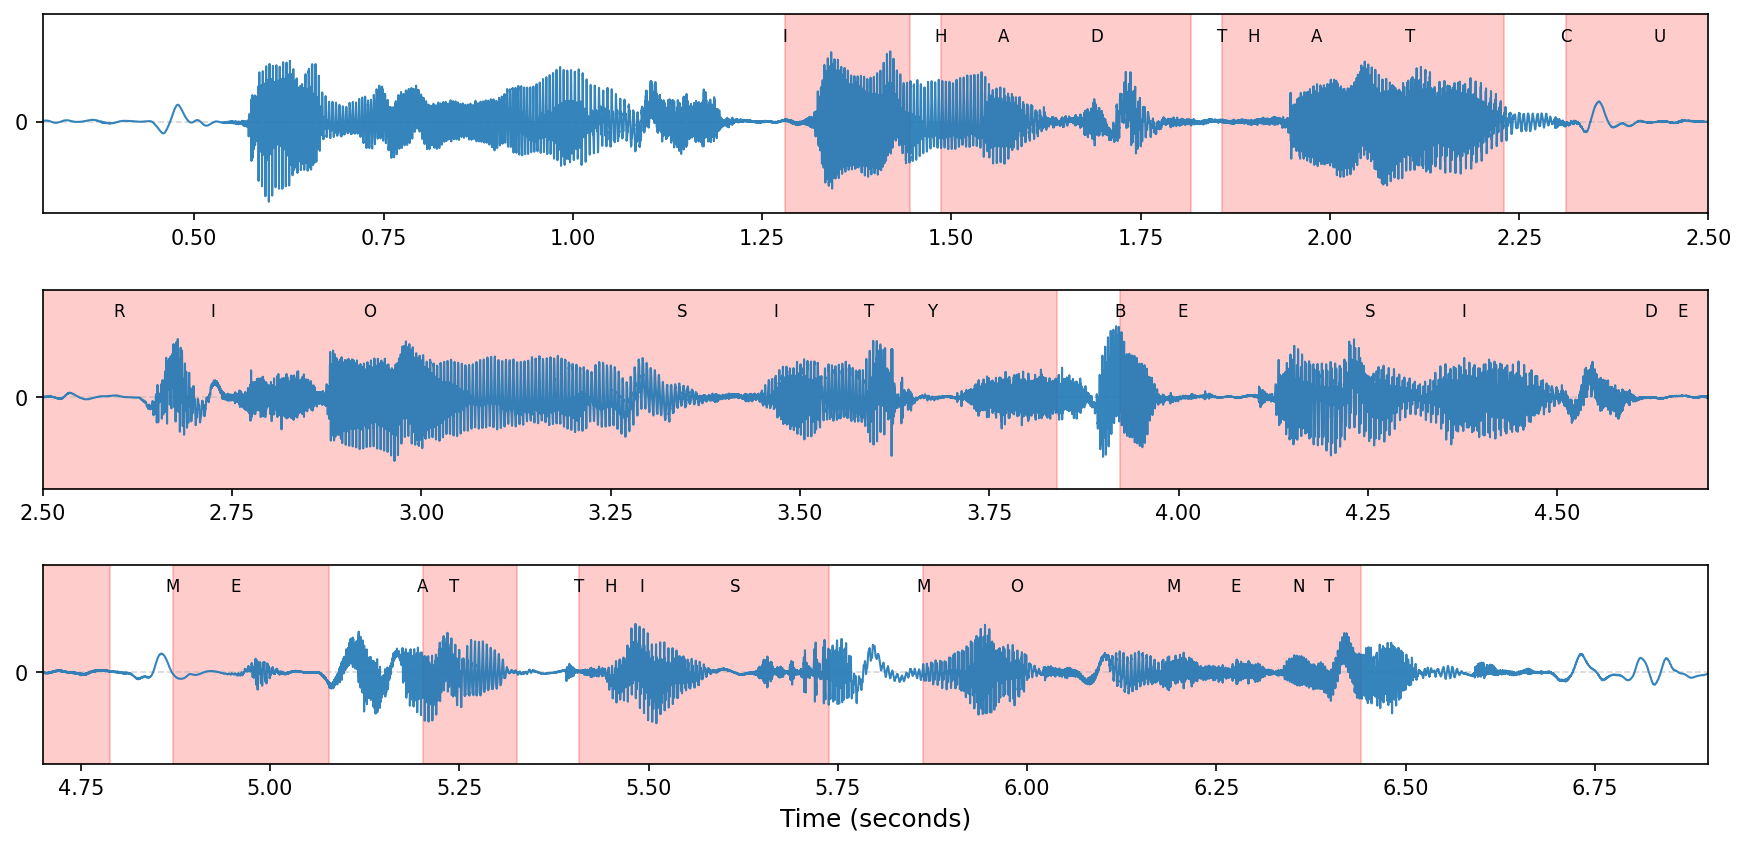

In [33]:
plot_alignments(waveform_tensor, out, predicted_tokens, timesteps, 16000)

## Conclusion 🚀
By switching to __Beam Search with a Language Model__, we observed a significant reduction in WER. Additionally, by tuning beam search parameters such as `nbest`, `beam_size`, `Word Weight`, and `Language Model Weight`, we can improve even better but at the cost of computational speed. ⚡📉